# Introducción a Redes Neuronales Recurrentes con Tensorflow
Este *Notebook* muestra como predecir valores de una serie de tiempo utilizando Redes Neuronales Recurrentes y Tensorflow. Cabe aclarar que el enfoque está en la implementación y no en la estrategia aplicada para el manejo de series de tiempo; por lo tanto, la escogencia de variables para el modelo así como su tratamiento, podrían no ser las mejores desde un punto de vista metodológico.

In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

Lo siguiente importa los datos de entrenamiento y de prueba, los cuales se encuentran en un archvio llamado DATA.csv dentro del mismo directorio que este *Notebook*.

In [2]:
df = pd.read_csv('DATA.csv', index_col=0, parse_dates=True)
df.head()

,Precio_Petroleo,Precio_Gas,Precio_Carbon,COP/USD
Fecha,,,,
2017-09-27,52.14,97.25,2.979,2937.47
2017-09-26,51.88,97.00,2.918,2923.85
2017-09-25,52.22,96.95,2.919,2925.92
2017-09-22,50.66,97.20,2.959,2906.03
2017-09-21,50.55,97.30,2.946,2915.71


Estos datos están en orden descendente, lo siguiente solo los convierte a orden ascendente

In [3]:
df.sort_index(inplace=True)
df.head()

,Precio_Petroleo,Precio_Gas,Precio_Carbon,COP/USD
Fecha,,,,
2008-12-05,40.81,72.30,5.742,2337.00
2008-12-08,43.71,73.60,5.566,2337.00
2008-12-09,42.07,74.15,5.579,2312.05
2008-12-10,43.52,73.75,5.686,2305.91
2008-12-11,47.98,76.90,5.598,2267.25


In [4]:
scaler = StandardScaler()
train_data = scaler.fit_transform(df['2008':'2016'].values)
test_data = scaler.transform(df['2017'].values)

En una aplicación real, las variables no se deben escalar de la forma en que se está haciendo acá, pero como este no es el objetivo de la presentación, los valores se escalaron de la forma más práctica

In [5]:
X_train, Y_train = train_data[:,:-1], train_data[:,-1].reshape(-1,1)
X_test, Y_test = test_data[:,:-1], test_data[:,-1].reshape(-1,1)

## Red Neuronal Recurrente Básica ###

Para esta presentación, vamos a asumir que el número de pasos que usaremos en la serie de tiempo es constante, pero podría hacerse para aceptar sequencias de longitud variable.

In [6]:
n_steps = 2
n_inputs = 3
n_outputs = 1
n_units = 10

** Definir el gráfico de Tensorflow ** para poder utilizar Tensorflow se debe crear un gráfico que describa el cómputo a realizar. Este especifica todas las variables del modelo: entradas, salidas, capas de la red, función a optimizar, etc. 

In [7]:
graph = tf.Graph()
with graph.as_default():
    
    ## Define las entradas y salidas del modelo
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    ## Define una capa de la red neuronal recurrente
    cell = tf.contrib.rnn.BasicRNNCell(
        num_units=n_units, activation=tf.nn.relu)
    ## Transforma la salida de los nodos en un solo valor
    cell_proj = tf.contrib.rnn.OutputProjectionWrapper(
        cell, output_size=n_outputs)
    
    ## Se encarga de desenrollar la red
    outputs, states = tf.nn.dynamic_rnn(cell_proj, X, dtype=tf.float32)
    
    ## Define la función de costo y la operación para optimizar
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    ## Define el inicalizador de variables y el objeto que guarda
    ## el modelo
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Ahora que se definió el gráfico, se procede a realizar el entrenamiento. Esto sucede en el contexto de una sessión.

In [8]:
def get_next_batch(data, n_steps, batch_size=100):
    """     
    Args:
        X (np.ndarray): matrix of predictor variables
        Y (np.ndarray): 2d ndarray of predicted variables
        n_steps (int): number of steps to considere in the series
        batch_size (int): size of the batch to be returned.
                
    Returns:
        X_batch: A tensor of shape (batch_size, # steps, # inputs),
            which corresponds to a batch of predictor variables
            along several steps.
        Y: A tensor of shape (batch_size, # steps, # outputs),
            which corresponds to a batch of predicted variables
            along several steps.
    """
    if isinstance(data, np.ndarray):
        data = [data]
    index_0 = np.random.choice(
        data[0].shape[0] - n_steps, size=(batch_size,1), replace=False)
    indices = index_0 + np.arange(n_steps)
    return tuple(X[indices] for X in data)

In [9]:
def shape_data(data, n_steps):
    """     
    Args:
        X (np.ndarray): matrix of predictor variables
        Y (np.ndarray): 2d ndarray of predicted variables
        n_steps (int): number of steps to considere in the series
        batch_size (int): size of the batch to be returned.
                        
    Returns:
        X_batch: A tensor of shape (batch_size, # steps, # variables),
            which corresponds to a batch of predictor variables
            along several steps.
        Y_batch: A tensor of shape (batch_size, # steps, # variables),
            which corresponds to a batch of predicted values
            along several steps.
    """
    if isinstance(data, np.ndarray):
        data = [data]
    indices = (np.arange(0, data[0].shape[0]-n_steps).reshape(-1, 1)
              +np.arange(n_steps))
    return tuple(X[indices] for X in data)
    

A continuación se definen los parámetros del entrenamiento

In [10]:
n_epochs = 2000
batch_size = 700

In [11]:
model_path = os.path.join(os.getcwd(),'basic_rnn')

In [12]:
with tf.Session(graph=graph) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Enternando modelo'))
    for epoch in range(n_epochs):
        ## De los datos de entrenamiento seleccione un batch
        X_batch, Y_batch = get_next_batch([X_train, Y_train], n_steps, batch_size)
        ## Ejecute la operación de entrenamiento definida
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        ## Calcule la función de costo cada cierto tiempo para visualizar
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

-----------Enternando modelo------------
0 	MSE: 0.843244
200 	MSE: 0.188139
400 	MSE: 0.103935
600 	MSE: 0.0860093
800 	MSE: 0.0690979
1000 	MSE: 0.0608666
1200 	MSE: 0.0550843
1400 	MSE: 0.0493008
1600 	MSE: 0.0560313
1800 	MSE: 0.0448418


In [13]:
with tf.Session(graph=graph) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((X_train, Y_train), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((X_test, Y_test), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.0447775
Error de prueba:  0.101229


Lo siguiente solo le da forma al *batch* calculado para poderlo graficar al lado de los datos de entrenamiento y prueba

In [14]:
def shape_output_2d(data):
    data[:,-1,:]

In [15]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

In [16]:
def plot_results(real, pred, n_steps, width=25, bheight=5):
    n_vars = real.shape[1]
    height = n_vars*bheight
    time = range(len(real)) 
    fig, *axarr = plt.subplots(n_vars, sharex=True, figsize=(width, height))
    try:
        enumerate(axarr)
    except TypeError:
        axarr.append(None)       
    for i, ax in enumerate(axarr):
        if ax is not None:
            ax.plot(time[:], real[:,i], color='b', alpha=0.65, label="Real")
            ax.plot(time[n_steps:], pred[:,i], color='r', alpha=0.65, label="Predicted")
            ax.legend(loc="best")
            ax.set_axisbelow(True)
            ax.grid(linestyle='--',color='0.7')
    plt.xlabel("Time")

Las predicciones sobre los datos de entrenamiento

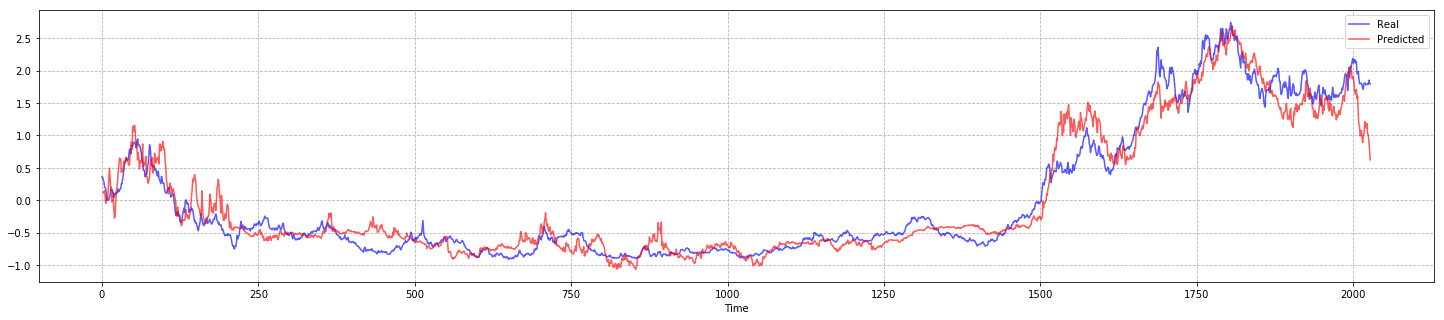

In [17]:
plot_results(Y_train, Y_train_pred, n_steps)

Predicciones sobre datos de prueba

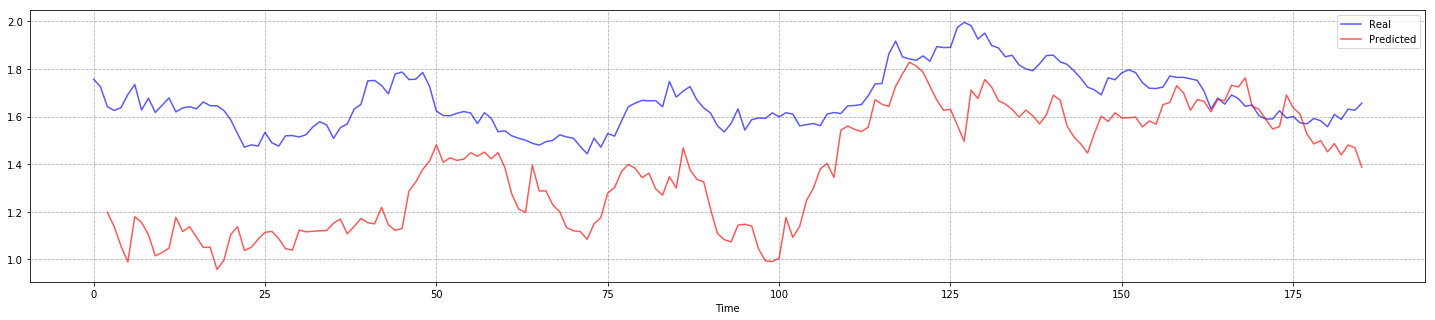

In [18]:
plot_results(Y_test, Y_test_pred, n_steps)

## Red Neuronal recurrente con LSTM
Ahora se evaluará una red neuronal con nodos LSTM en lugar de los regulares (el código es casi el mismo que para el caso anterior)

In [19]:
graph_lstm = tf.Graph()
with graph_lstm.as_default():
    
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    ## Acá se debe seleccionar el tipo de nodo recurrente que se desea
    cell = tf.contrib.rnn.BasicLSTMCell(
        num_units=n_units, activation=tf.sigmoid)
    
    cell_proj = tf.contrib.rnn.OutputProjectionWrapper(
        cell, output_size=n_outputs)
    
    outputs, states = tf.nn.dynamic_rnn(cell_proj, X, dtype=tf.float32)
    
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

**Nota:**La documentación de [BasicLSTMCell](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/BasicLSTMCell) en Tensorflow, dice que por defecto usan activación $tanh$ para los estados internos de LSTM; sin embargo, en la [literatura](http://www.deeplearningbook.org/contents/rnn.html) generalmente se muestran utilizando $sigmoid$ para la activación.

In [20]:
model_path = os.path.join(os.getcwd(),'basic_LSTM')

In [21]:
with tf.Session(graph=graph_lstm) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Entrenando modelo'))
    for epoch in range(n_epochs):
        X_batch, Y_batch = get_next_batch((X_train, Y_train), n_steps, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

-----------Entrenando modelo------------
0 	MSE: 0.944266
200 	MSE: 0.387582
400 	MSE: 0.252482
600 	MSE: 0.179953
800 	MSE: 0.146658
1000 	MSE: 0.141404
1200 	MSE: 0.112579
1400 	MSE: 0.107958
1600 	MSE: 0.107244
1800 	MSE: 0.0972728


In [22]:
with tf.Session(graph=graph_lstm) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((X_train, Y_train), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((X_test, Y_test), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.0886112
Error de prueba:  0.351267


In [23]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

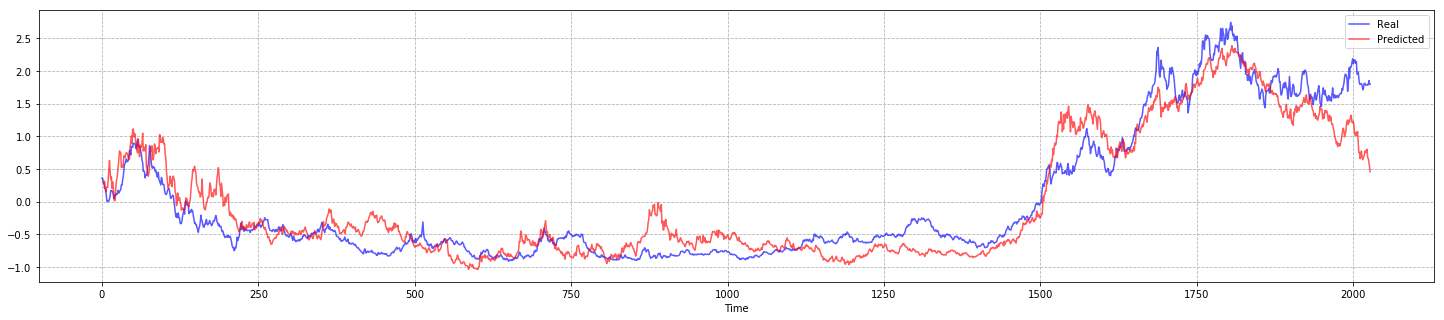

In [24]:
plot_results(Y_train, Y_train_pred, n_steps)

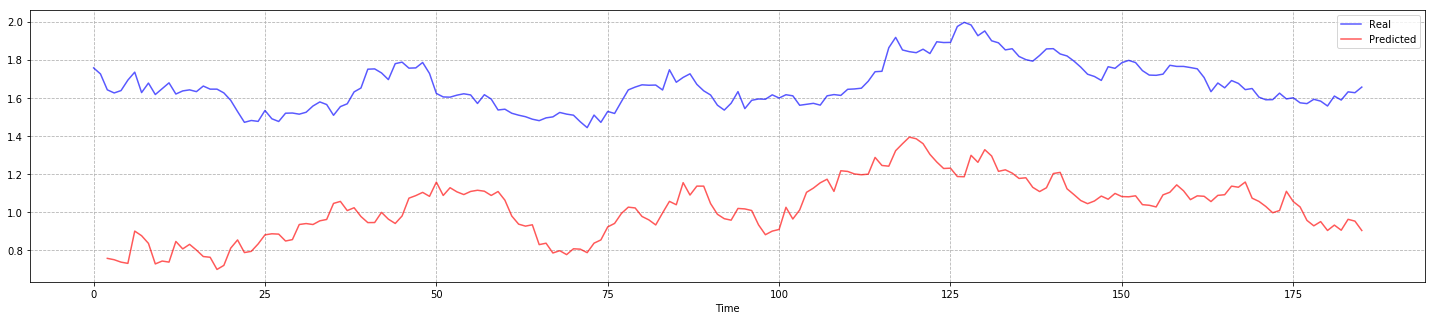

In [25]:
plot_results(Y_test, Y_test_pred, n_steps)

## Otros tipos de RNN
Existen otros tipos de RNN para usar con Tensorflow. Por ejemplo *Gated Recurrent Units* [GRU](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/GRUCell). Para utilizar esto en los modelos simplemente se debe remplazar la línea *cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_units, activation=tf.sigmoid)* en el grafo.

## Utilizando un modelo profundo
Para cualquiera de las redes usadas, es posible aumentar el número de capas del modelo, lo que se traduciría en mayor capacidad de aprendizaje (y más riesgo de sobre estimación). Para esto, solo hace falta crear cada capa de manera independiente y agruparla en un objeto de la clase MultiRNNCell

In [26]:
n_units_per_layer = (8,4,2)

In [27]:
graph_lstm_deeper = tf.Graph()
with graph_lstm_deeper.as_default():
    
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    ## Se crean la cantidad de capas
    layers = [tf.contrib.rnn.BasicLSTMCell(num_units=nu, activation=tf.sigmoid)
             for nu in n_units_per_layer]
    ## y luego se agrupan
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    
    cell_proj = tf.contrib.rnn.OutputProjectionWrapper(
        multi_layer_cell, output_size=n_outputs)
    
    outputs, _ = tf.nn.dynamic_rnn(cell_proj, X, dtype=tf.float32)
    
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [28]:
model_path = os.path.join(os.getcwd(),'deeper_LSTM')

In [29]:
with tf.Session(graph=graph_lstm_deeper) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Entrenando el modelo'))
    for epoch in range(n_epochs):
        X_batch, Y_batch = get_next_batch((X_train, Y_train), n_steps, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

----------Entrenando el modelo----------
0 	MSE: 1.05627
200 	MSE: 0.936287
400 	MSE: 0.642274
600 	MSE: 0.447054
800 	MSE: 0.306034
1000 	MSE: 0.173876
1200 	MSE: 0.158445
1400 	MSE: 0.126389
1600 	MSE: 0.104623
1800 	MSE: 0.0930506


In [30]:
with tf.Session(graph=graph_lstm_deeper) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((X_train, Y_train), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((X_test, Y_test), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.0831532
Error de prueba:  0.101269


In [31]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

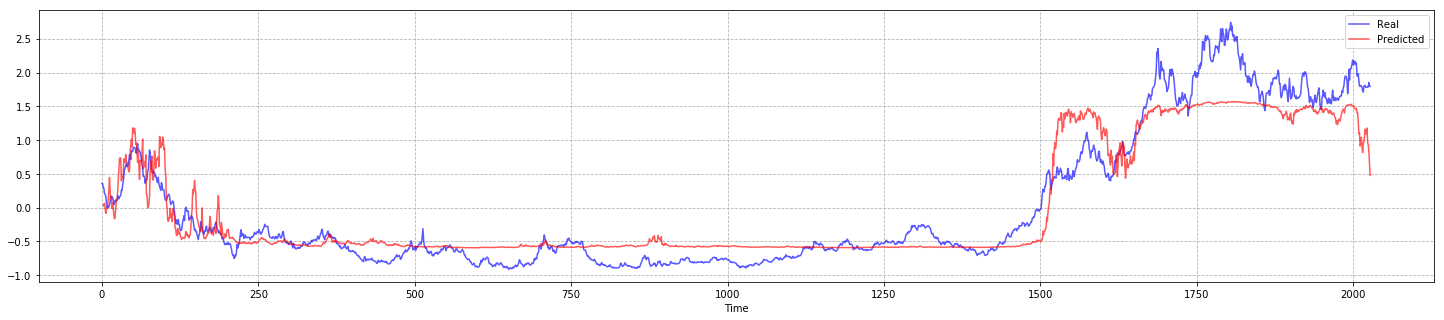

In [32]:
plot_results(Y_train, Y_train_pred, n_steps)

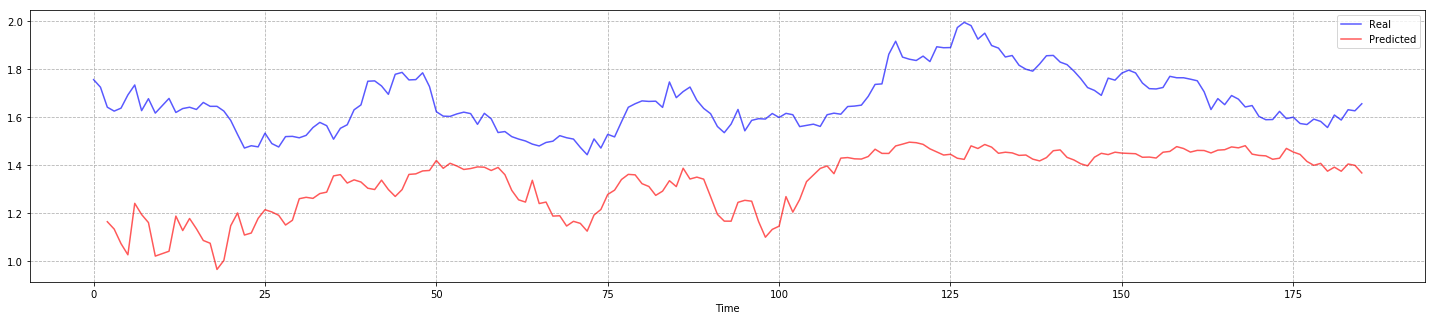

In [33]:
plot_results(Y_test, Y_test_pred, n_steps)

## Comparando las RNN con Feedforward NN
Cuál sería el resultado de aplicar una red neuronal similar a las anteriores pero sin conexiones recurrentes?

In [34]:
graph_ffnn = tf.Graph()
with graph_ffnn.as_default():
    
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    layer1 = tf.layers.dense(inputs=X, units=n_units, activation=tf.nn.relu)
    outputs = tf.layers.dense(inputs=layer1, units=1, activation=None)
    
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [35]:
model_path = os.path.join(os.getcwd(),'ffnn')

In [36]:
with tf.Session(graph=graph_ffnn) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Entrenando modelo'))
    for epoch in range(n_epochs):
        X_batch, Y_batch = get_next_batch((X_train, Y_train), n_steps, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

-----------Entrenando modelo------------
0 	MSE: 1.25399
200 	MSE: 0.266458
400 	MSE: 0.130103
600 	MSE: 0.0940828
800 	MSE: 0.0689191
1000 	MSE: 0.0623464
1200 	MSE: 0.0593852
1400 	MSE: 0.0532666
1600 	MSE: 0.0533857
1800 	MSE: 0.0476435


In [37]:
with tf.Session(graph=graph_ffnn) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((X_train, Y_train), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((X_test, Y_test), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.0505062
Error de prueba:  0.131273


In [38]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

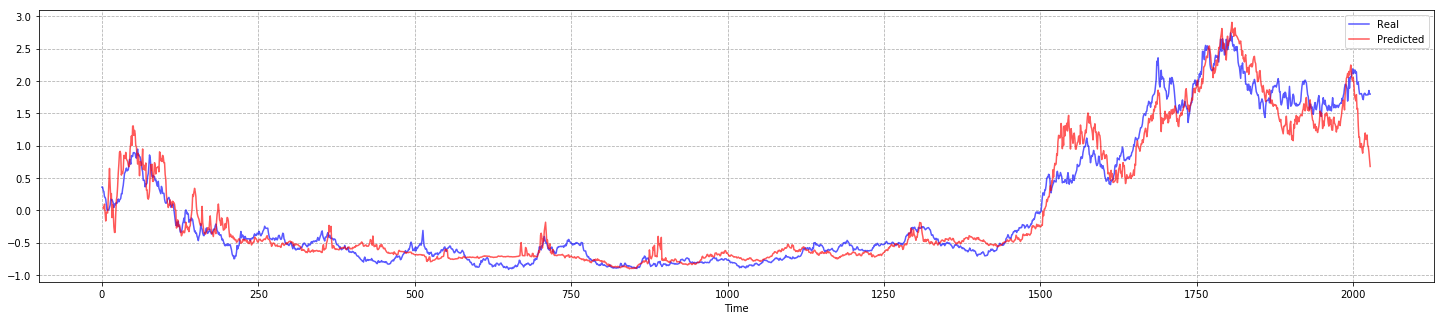

In [39]:
plot_results(Y_train, Y_train_pred, n_steps)

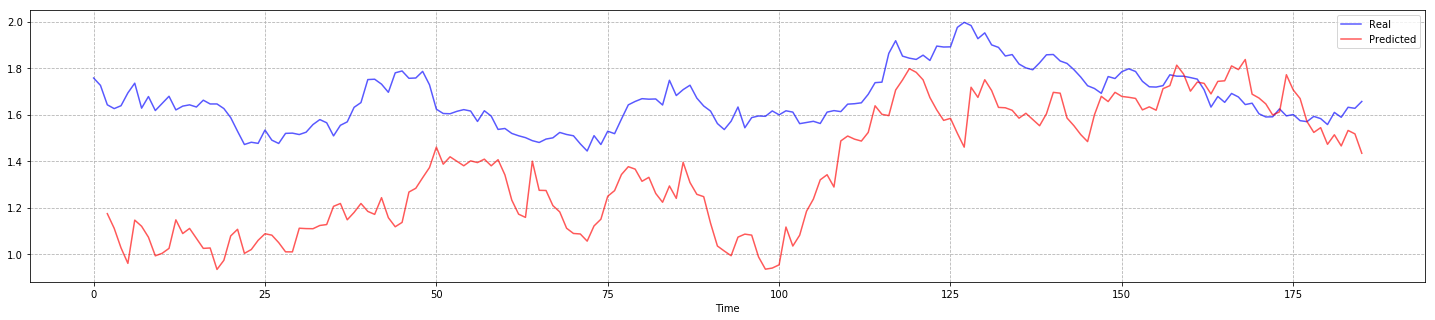

In [40]:
plot_results(Y_test, Y_test_pred, n_steps)

## Comparando el modelo con una simple regresión lineal
podríamos obtener un mejor resultado que con una regresión lineal?

In [41]:
graph_ols = tf.Graph()
with graph_ols.as_default():
    
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    outputs = tf.layers.dense(inputs=X, units=1, activation=None)
    
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [42]:
model_path = os.path.join(os.getcwd(),'ols')

In [43]:
with tf.Session(graph=graph_ols) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Entrenando modelo'))
    for epoch in range(n_epochs):
        X_batch, Y_batch = get_next_batch((X_train, Y_train), n_steps, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

-----------Entrenando modelo------------
0 	MSE: 3.73977
200 	MSE: 2.44831
400 	MSE: 1.35227
600 	MSE: 0.840712
800 	MSE: 0.540105
1000 	MSE: 0.37519
1200 	MSE: 0.270685
1400 	MSE: 0.23151
1600 	MSE: 0.219405
1800 	MSE: 0.20344


In [44]:
with tf.Session(graph=graph_ols) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((X_train, Y_train), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((X_test, Y_test), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.190451
Error de prueba:  0.677851


In [45]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

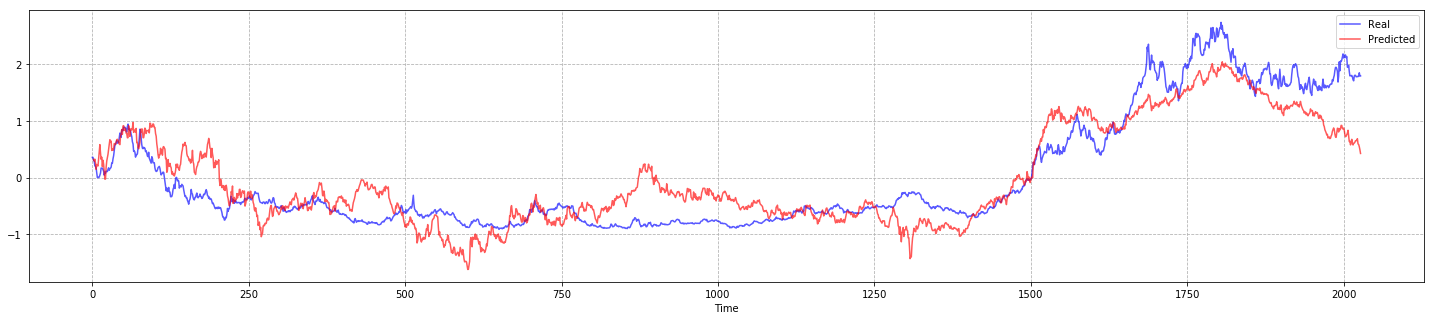

In [46]:
plot_results(Y_train, Y_train_pred, n_steps)

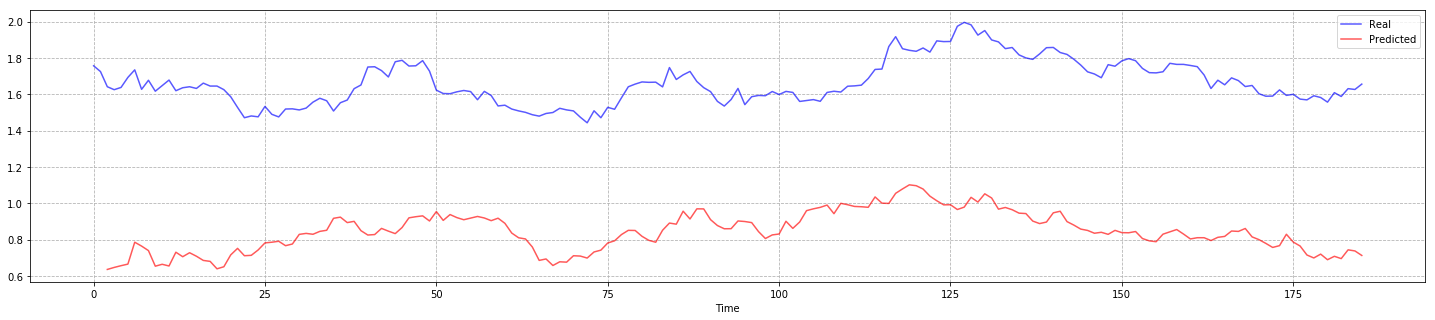

In [47]:
plot_results(Y_test, Y_test_pred, n_steps)

**RESPUESTA:** NO

## Qué pasa si no usamos variables predictoras?
En algunos casos podría re-entrenarse el modelo apartir de cada valor que se va obteniendo en el tiempo.

In [57]:
Y_train_next = Y_train[:-1]
Y_train_prev = Y_train[1:]
Y_test_next = Y_test[:-1]
Y_test_prev = Y_test[1:]

In [58]:
n_inputs = n_outputs = 1

In [59]:
graph_no_predictors = tf.Graph()
with graph_no_predictors.as_default():
    
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs), name='X')
    Y = tf.placeholder(tf.float32, (None, n_steps, n_outputs), name='Y')
    
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_units, activation=tf.sigmoid)
                
    cell_proj = tf.contrib.rnn.OutputProjectionWrapper(
        cell, output_size=n_outputs)
    
    outputs, _ = tf.nn.dynamic_rnn(cell_proj, X, dtype=tf.float32)
    
    loss = tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [60]:
model_path = os.path.join(os.getcwd(),'basic_no_predictors')

In [61]:
with tf.Session(graph=graph_no_predictors) as sess:
    init.run() # Inicializar las variables del gráfico
    print('{:-^40}'.format('Entrenando el modelo'))
    for epoch in range(n_epochs):
        X_batch, Y_batch = get_next_batch((Y_train_prev, Y_train_next),
                                          n_steps, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        if epoch % int(n_epochs*0.1) == 0:
            mse = loss.eval(feed_dict={X: X_batch, Y: Y_batch})
            print(epoch, '\tMSE:', mse)
            
    saver.save(sess, model_path)

----------Entrenando el modelo----------
0 	MSE: 1.12983
200 	MSE: 0.702513
400 	MSE: 0.225004
600 	MSE: 0.0887911
800 	MSE: 0.04802
1000 	MSE: 0.0248593
1200 	MSE: 0.00687269
1400 	MSE: 0.00390982
1600 	MSE: 0.00287757
1800 	MSE: 0.00240252


In [62]:
with tf.Session(graph=graph_no_predictors) as sess:    
    saver.restore(sess, model_path)
    print('{:-^40}'.format('Rendimiento del modelo'))       
    X_batch, Y_batch = shape_data((Y_train_prev, Y_train_next), n_steps)
    Y_train_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de entrenamiento: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))
    X_batch, Y_batch = shape_data((Y_test_prev, Y_test_next), n_steps)
    Y_test_pred = outputs.eval(feed_dict={X: X_batch})
    print('Error de prueba: ',
          loss.eval(feed_dict={X: X_batch, Y: Y_batch}))

---------Rendimiento del modelo---------
Error de entrenamiento:  0.00263139
Error de prueba:  0.00248477


In [63]:
shape_output_2d(Y_train_pred)
shape_output_2d(Y_test_pred)

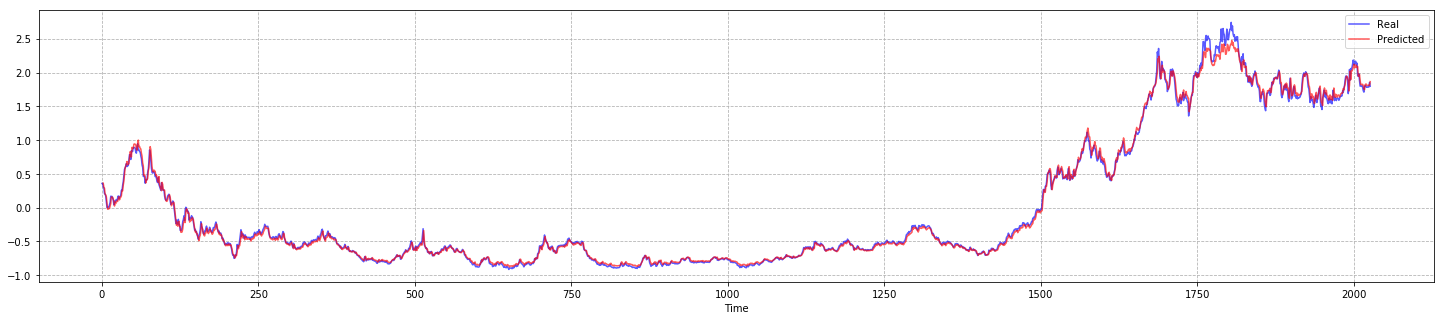

In [64]:
plot_results(Y_train_next, Y_train_pred, n_steps)

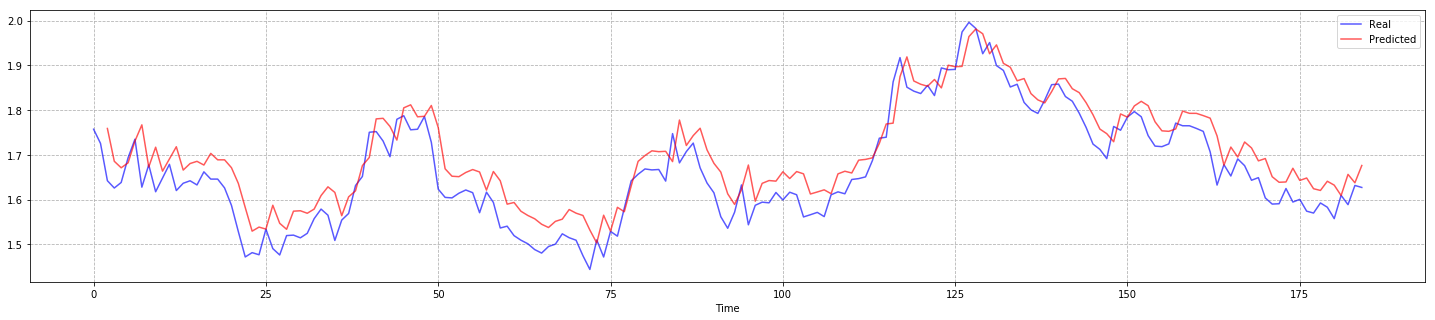

In [65]:
plot_results(Y_test_next, Y_test_pred, n_steps)